# RWTH Hack Mining 

## Track Drive Condition Monitoring of Mining Excavators (Komatsu)

## Overview: 

It is crucial to know the wear status of mining excavator track drives, because that helps to avoid costly unplanned downtime. To improve the current situation of risky and time-consuming manual geometric measurements, a concept of an automatic wear monitoring has been developed, that aims for detecting the wear during regular operation. As a proof of concept, a few hundred events were measured on a 550t-excavator and manually analyzed. Depending on the operating conditions, evaluation of different physical effects visible in sensor data allows conclusions to the current wear of the track drive. The task is to design an automatic algorithm to estimates the wear by evaluating the course of signals. To achieve that, toolboxes from Matlab (Signal Processing, Neural Network, Statistical) are to be applied. The outcome of the approaches should be validated by the manual evaluation results. To get you on track, an overview of the physics, videos and prepared sensor data will be provided. Take up the challenge and help make mining safer & smarter. Everyone, in particular students from engineering and computer science, is welcome. 


### 1. Import Relavent Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from scipy.ndimage import gaussian_filter1d


### 2.  Data Pre Processing
#### 2.1 Import Data using Pandas

note: change the file path on your system

In [2]:
#get the data overview
data_path = '/home/ayushman/Projects/Hackmining_Hackathon/RWTH_Hackmining_Hackathon/data/Track_wear_m06_spot_turn.xlsx'
df_raw = pd.read_excel(data_path , engine = 'openpyxl') 
df_raw.head()

,Zeit -,n_sprocket_left - U/min,x_sprocket_left - mm,torque_travel_left - Nm,torque_travel_right - Nm,p_track_tension_left - bar,p_track_tension_right - bar
0,0.000000,0.000034,0.000000,1.321088,0.250282,39.281631,52.370979
1,0.000833,0.000034,0.000003,1.382598,0.224518,39.274406,52.369591
2,0.001667,0.000034,0.000005,1.266326,0.267108,39.260303,52.369404
3,0.002500,0.000034,0.000008,1.197580,0.344828,39.264931,52.369606
4,0.003333,0.000034,0.000011,1.277175,0.299051,39.273117,52.369202


#### 2.2 Plot Data 

**2.2.1 Torque and RPM Separately**

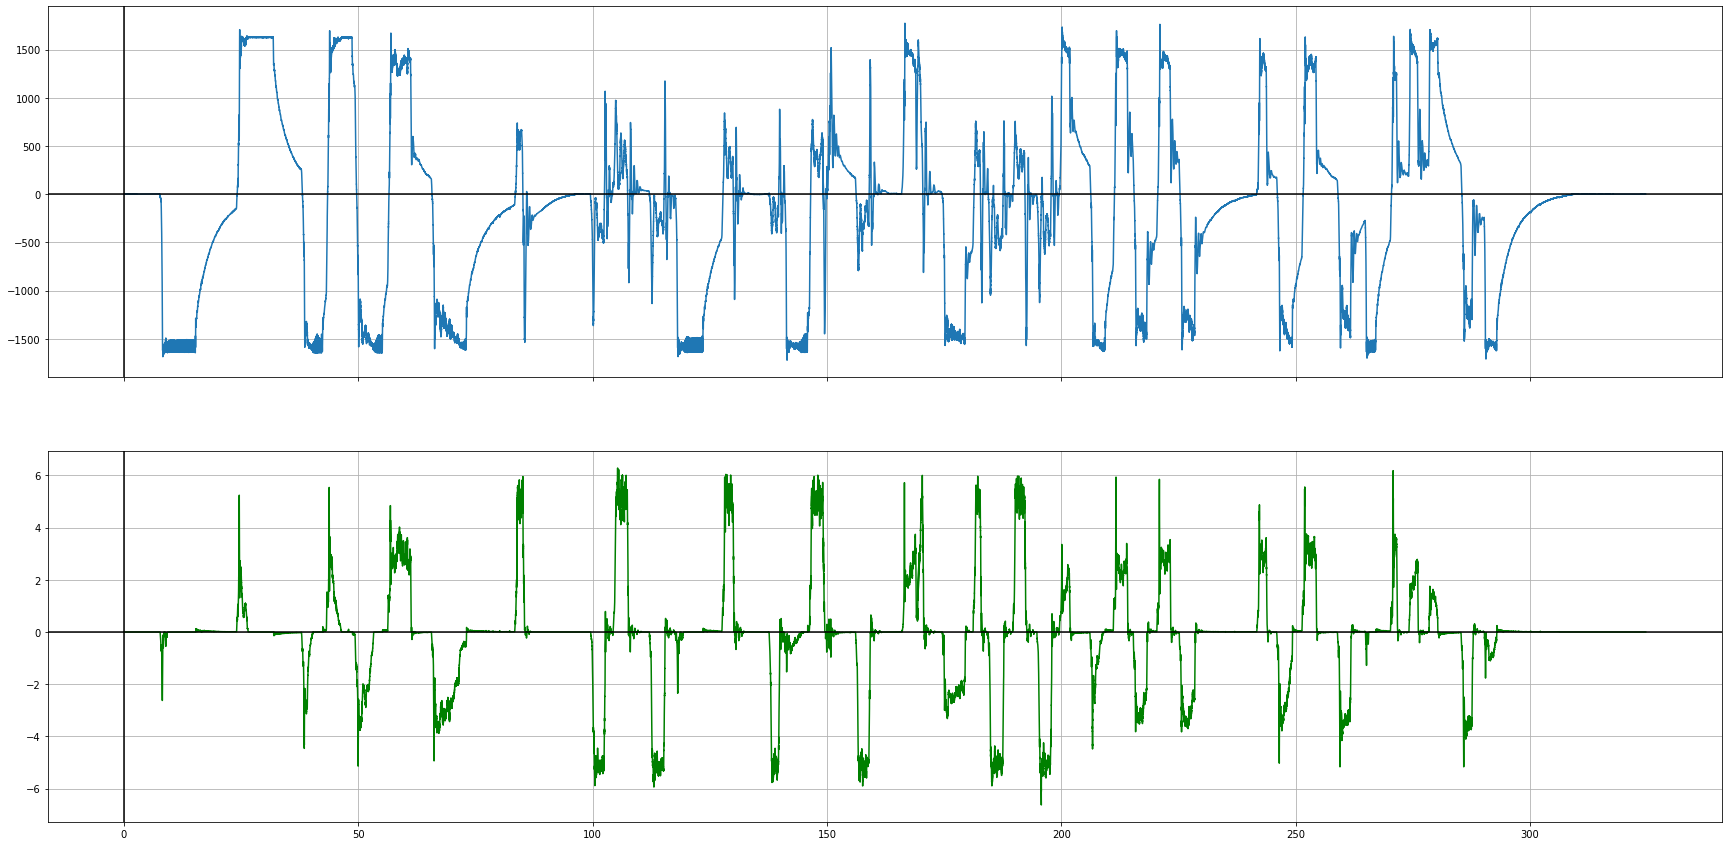

In [3]:
rpm_raw = df_raw["n_sprocket_left - U/min"]
torque_raw = df_raw["torque_travel_left - Nm"]
time = df_raw["Zeit - "]
fig, ax = plt.subplots(2,1, figsize = (30,15), sharex=True)
ax[0].plot(time, torque_raw )
ax[0].grid(True, which='both')
ax[0].axhline(y=0, color='k')
ax[0].axvline(x=0, color='k')

ax[1].plot(time, rpm_raw , 'g')
ax[1].grid(True, which='both')
ax[1].axhline(y=0, color='k')
ax[1].axvline(x=0, color='k')

**2.2.2 Plot Data - Torque and RPM together after data normalization**

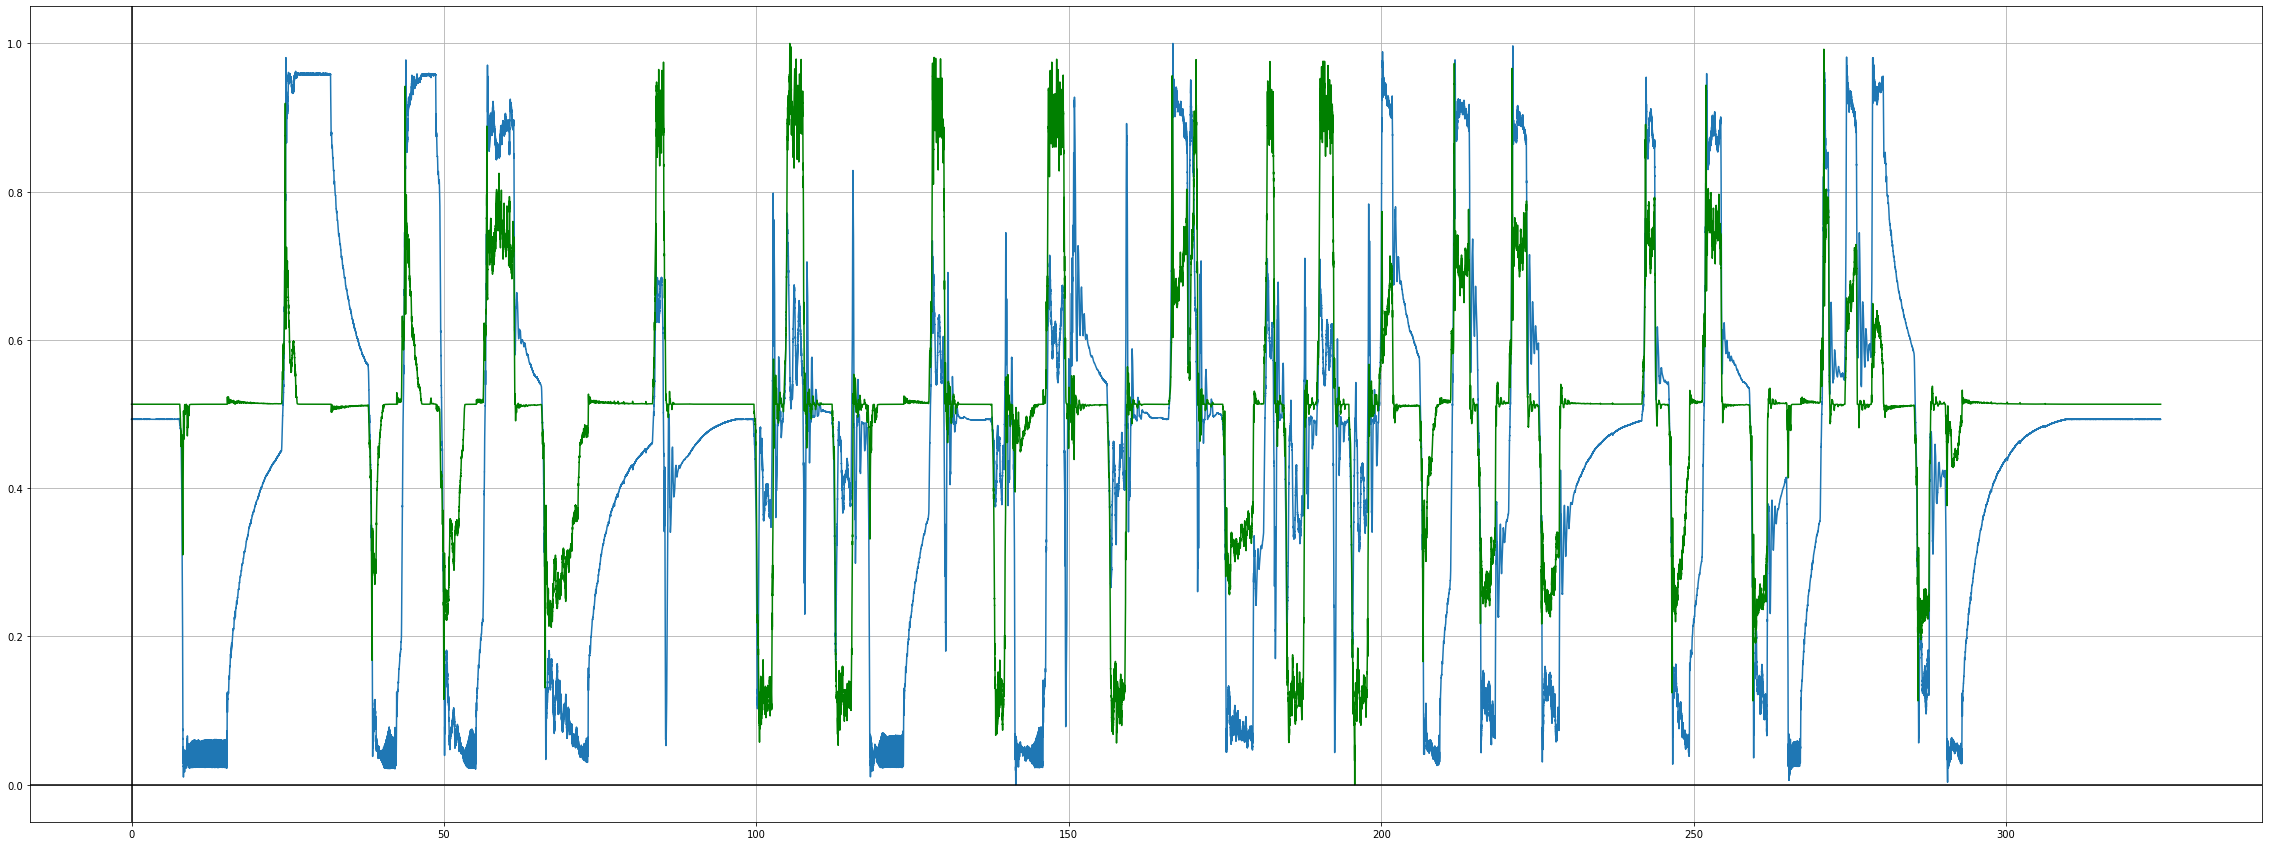

In [4]:

torque_raw_norm = (torque_raw-torque_raw.min())/(torque_raw.max()-torque_raw.min())
rpm_raw_norm = (rpm_raw-rpm_raw.min())/(rpm_raw.max()-rpm_raw.min())

fig, ax = plt.subplots(1,1, figsize = (40,15))
ax.plot(time, torque_raw_norm )
ax.plot(time, rpm_raw_norm , 'g' )
ax.grid(True, which='both')
ax.axhline(y=0, color='k')
ax.axvline(x=0, color='k')


#### 2.3  Data Smoothening - Simple Moving Average Filter

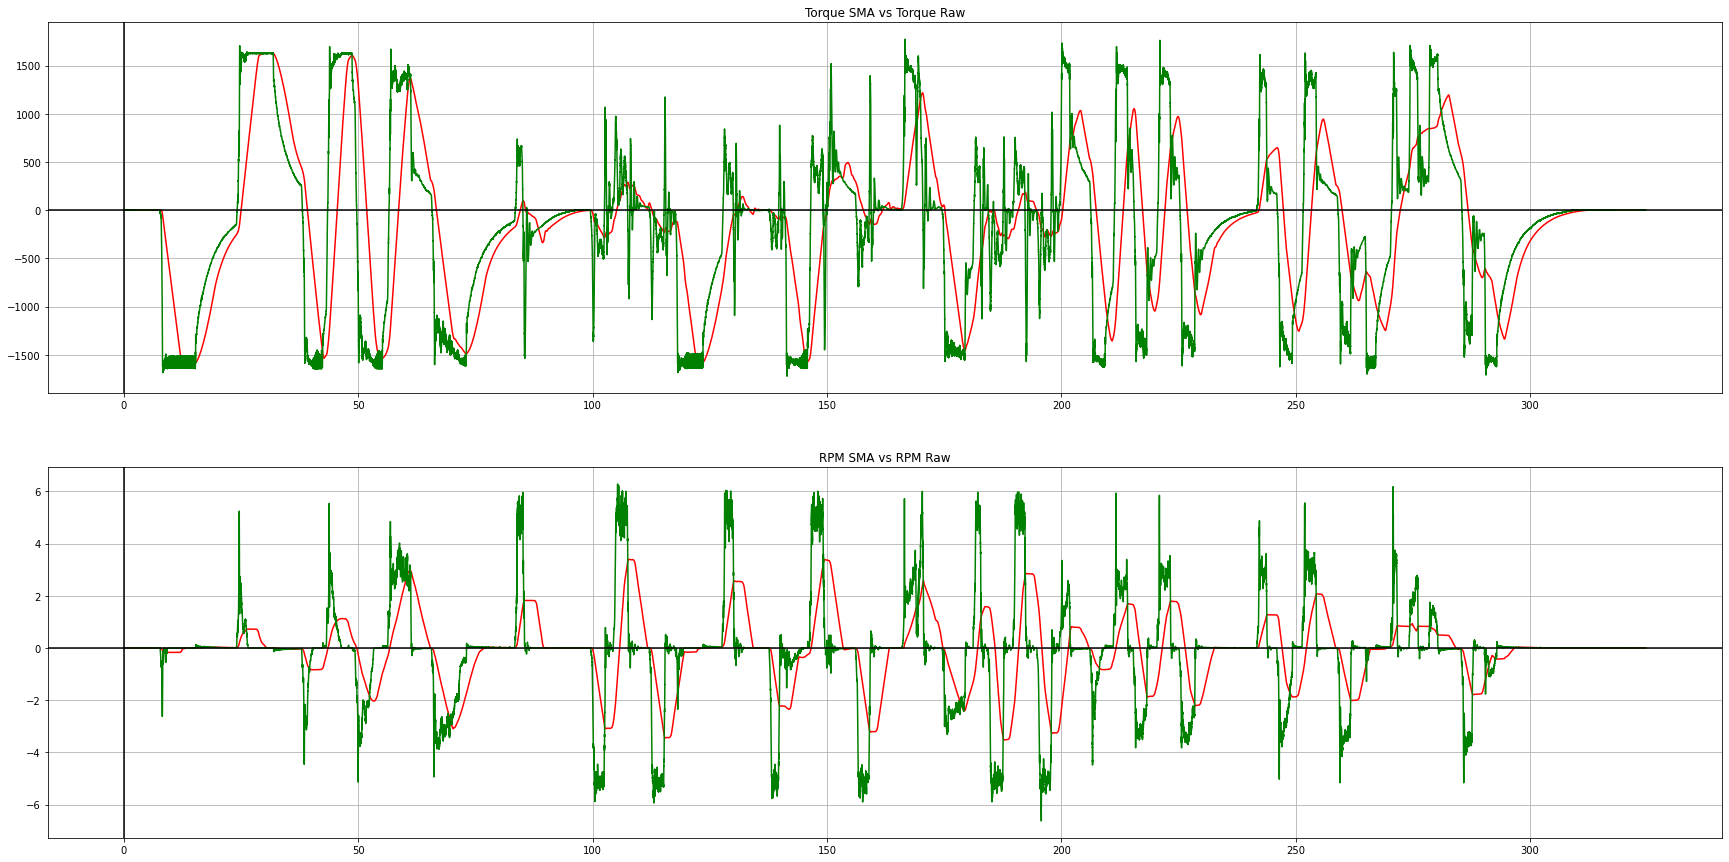

In [5]:
# torque and RPM smoothening using Simple Moving Average (SMA)

SMA_WIN_SIZE = 5000 #SMA window size

torque_SMA= torque_raw.rolling(SMA_WIN_SIZE, min_periods=1).mean()
rpm_SMA= rpm_raw.rolling(SMA_WIN_SIZE, min_periods=1).mean()


fig, ax = plt.subplots(2,1, figsize=(30, 15))
ax[0].plot(time, torque_SMA , 'r')
ax[0].plot(time, torque_raw , 'g')
ax[0].grid(True, which='both')
ax[0].axhline(y=0, color='k')
ax[0].axvline(x=0, color='k')
ax[0].title.set_text('Torque SMA vs Torque Raw')

ax[1].plot(time, rpm_SMA , 'r')
ax[1].plot(time, rpm_raw , 'g')
ax[1].grid(True, which='both')
ax[1].axhline(y=0, color='k')
ax[1].axvline(x=0, color='k')
ax[1].title.set_text('RPM SMA vs RPM Raw')



#### 2.4: Data Smoothening - Gaussian FIltering

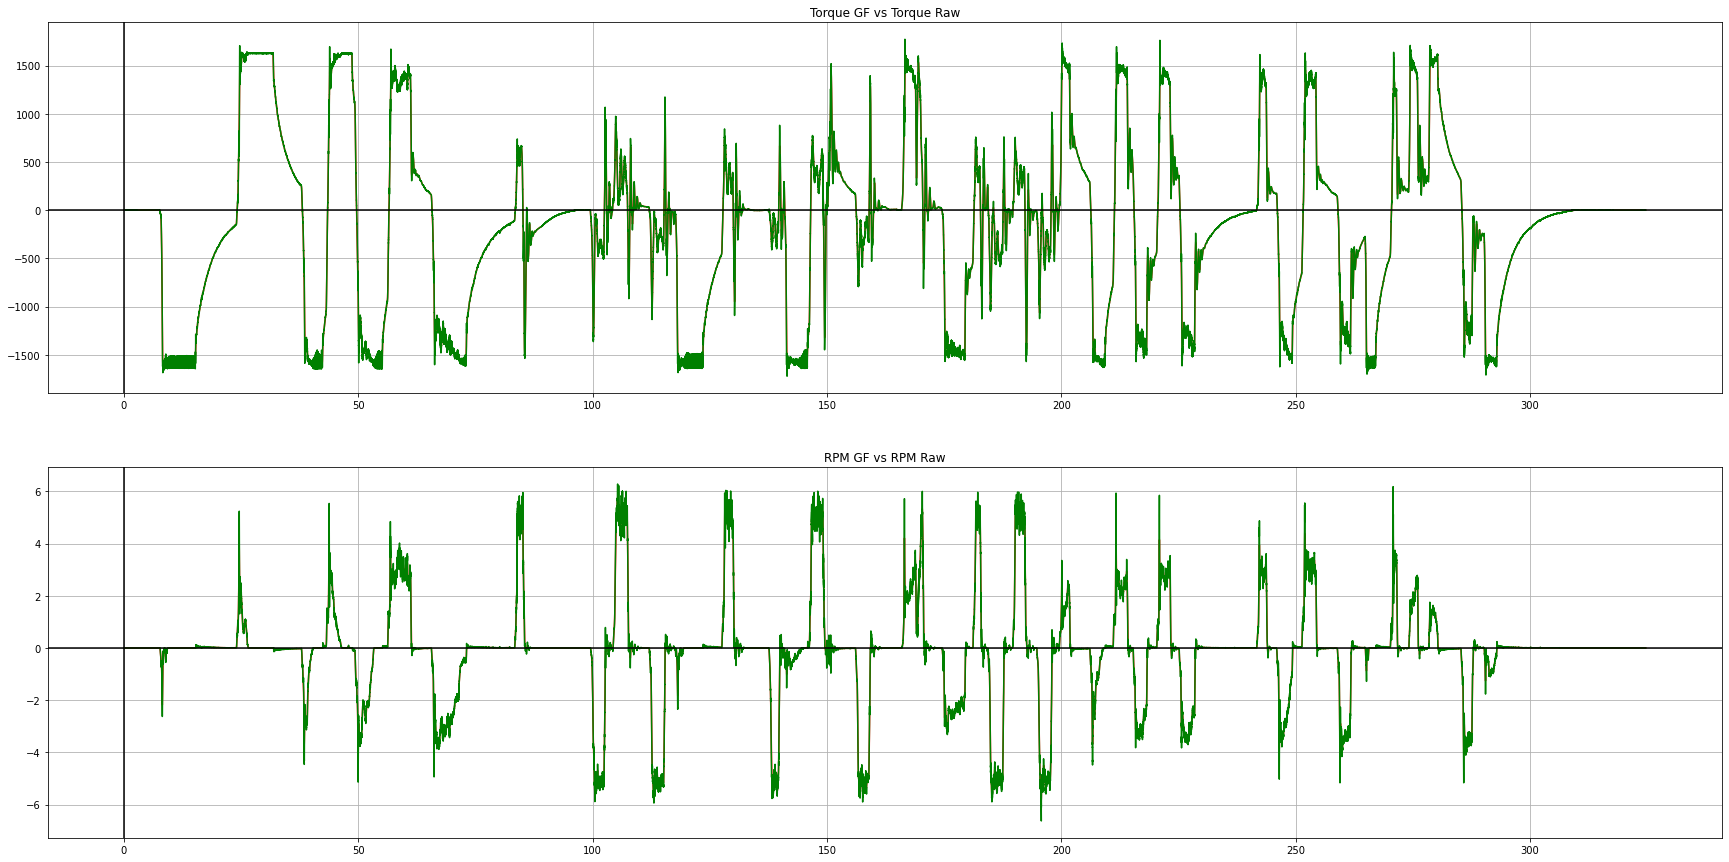

In [6]:
GAUSS_FILTER_STD_DEV = 50

torque_GF = gaussian_filter1d(torque_raw, GAUSS_FILTER_STD_DEV)
rpm_GF = gaussian_filter1d(rpm_raw , GAUSS_FILTER_STD_DEV)

fig, ax = plt.subplots(2,1, figsize=(30, 15))
ax[0].plot(time, torque_GF , 'r')
ax[0].plot(time, torque_raw , 'g')
ax[0].grid(True, which='both')
ax[0].axhline(y=0, color='k')
ax[0].axvline(x=0, color='k')
ax[0].title.set_text('Torque GF vs Torque Raw')

ax[1].plot(time, rpm_GF , 'r')
ax[1].plot(time, rpm_raw , 'g')
ax[1].grid(True, which='both')
ax[1].axhline(y=0, color='k')
ax[1].axvline(x=0, color='k')
ax[1].title.set_text('RPM GF vs RPM Raw')

#### 2.4 Dataset Splitting 

 **2.4.1 Zero Crossing Detection** 

In [7]:
def zero_crossing_detection(data_frame):

    zero_crossing_index = np.array([0])
    
    for data_sample in range(0,data_frame.size) :
       
        if data_sample == data_frame.size-1 : 
            
            zero_crossing_index = np.delete(zero_crossing_index, 0)
            
            return zero_crossing_index
        
        if ((data_frame.iloc[data_sample] <= 0) and (data_frame.iloc[data_sample+1] >= 0)) or ((data_frame.iloc[data_sample] >= 0) and (data_frame.iloc[data_sample+1] <= 0)) : 
            
            zero_crossing_index = np.append(zero_crossing_index , data_sample)
            

In [8]:
torque_GF_df = pd.DataFrame(torque_GF, columns = [' Torque_GF'] )
torque_GF = torque_GF_df[' Torque_GF']

rpm_GF_df = pd.DataFrame(rpm_GF, columns = [' rpm_GF'] )
rpm_GF = rpm_GF_df[' rpm_GF']

torque_zero_crossing_index = zero_crossing_detection(torque_GF)
rpm_zero_crossing_index = zero_crossing_detection(rpm_raw)

#print(torque_zero_crossing_index)
#print(rpm_zero_crossing_index)

**2.4.2 Dataset Splitting**

In [9]:
#split data (only extracted the first data set)

split_index_1 = torque_zero_crossing_index[3]
split_index_2 = torque_zero_crossing_index[4] 

df_raw_1 = df_raw.iloc[split_index_1:split_index_2, :]
torque_GF_1 = torque_GF.iloc[split_index_1:split_index_2]
rpm_GF_1 = rpm_GF.iloc[split_index_1:split_index_2]

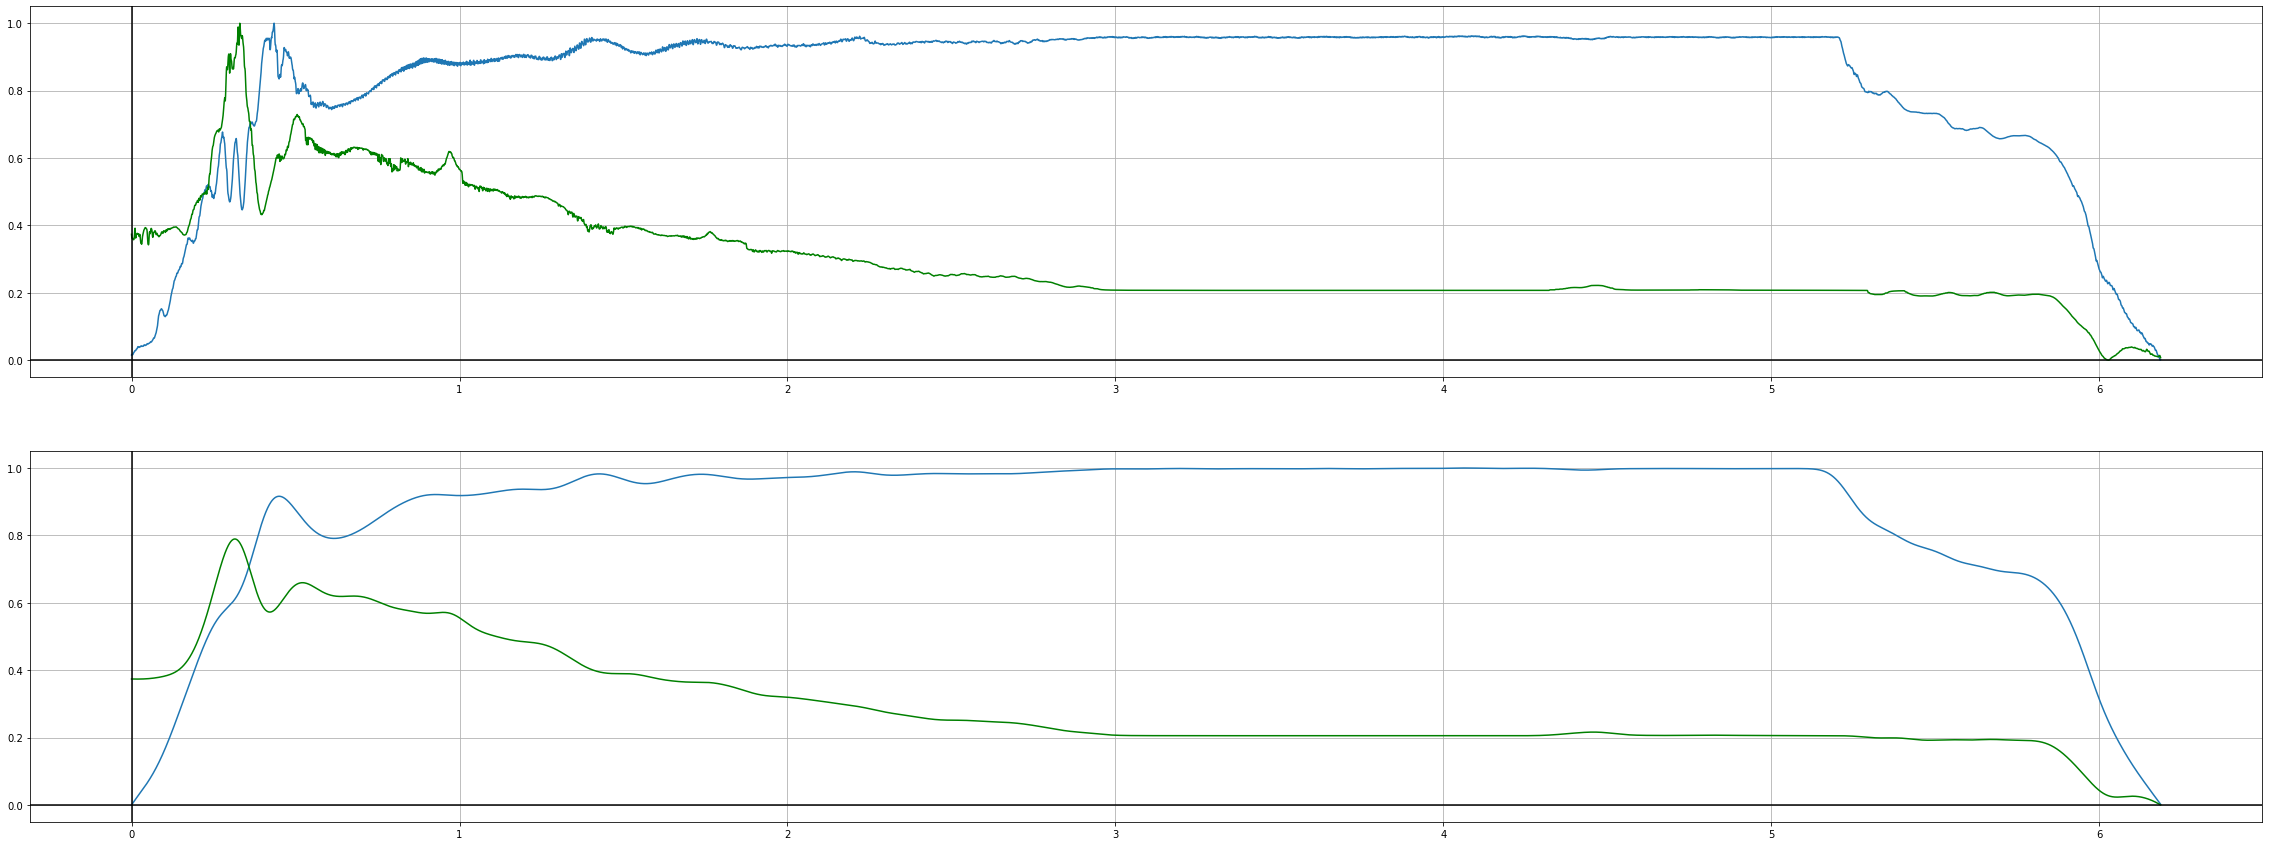

In [10]:
# Plot normalized data
rpm_raw = df_raw_1["n_sprocket_left - U/min"]
torque_raw = df_raw_1["torque_travel_left - Nm"]
time = df_raw_1["Zeit - "] - df_raw_1["Zeit - "].min() #to compensate for the time shift while splitting

torque_raw_norm = (torque_raw-torque_raw.min())/(torque_raw.max()-torque_raw.min())
rpm_raw_norm = (rpm_raw-rpm_raw.min())/(rpm_raw.max()-rpm_raw.min())

torque_GF_norm = (torque_GF_1-torque_GF_1.min())/(torque_GF_1.max()-torque_GF_1.min())
rpm_GF_norm = (rpm_GF_1-rpm_GF_1.min())/(rpm_raw.max()-rpm_GF_1.min())

fig, ax = plt.subplots(2,1, figsize = (40,15))
ax[0].plot(time, torque_raw_norm )
ax[0].plot(time, rpm_raw_norm , 'g' )
ax[0].grid(True, which='both')
ax[0].axhline(y=0, color='k')
ax[0].axvline(x=0, color='k')


ax[1].plot(time, torque_GF_norm )
ax[1].plot(time, rpm_GF_norm , 'g' )
ax[1].grid(True, which='both')
ax[1].axhline(y=0, color='k')
ax[1].axvline(x=0, color='k')
